In [2]:
import sys
sys.path.append('..')

In [3]:
from spinesTS.data import *
series_data = BuiltInSeriesData(print_file_list=True)
df_a = series_data['ETTh1']  # series_data[0], it works, too
print(type(df_a))

+---+----------------------+----------------------------------------------+
|   | ds name              | columns                                      |
+---+----------------------+----------------------------------------------+
| 0 | ETTh1                | date, HUFL, HULL, MUFL, MULL, LUFL, LULL, OT |
| 1 | ETTh2                | date, HUFL, HULL, MUFL, MULL, LUFL, LULL, OT |
| 2 | ETTm1                | date, HUFL, HULL, MUFL, MULL, LUFL, LULL, OT |
| 3 | ETTm2                | date, HUFL, HULL, MUFL, MULL, LUFL, LULL, OT |
| 4 | Electric_Production  | date, value                                  |
| 5 | Messages_Sent        | date, ta, tb, tc                             |
| 6 | Messages_Sent_Hour   | date, hour, ta, tb, tc                       |
| 7 | Supermarket_Incoming | date, goods_cnt                              |
| 8 | Web_Sales            | date, type_a, type_b, sales_cnt              |
+---+----------------------+----------------------------------------------+
<class 'spin

In [4]:
from spinesTS.preprocessing._denoise import moving_average

# MultiForecast

In [5]:
from spinesTS.data import *
from spinesTS.preprocessing import split_series
from spinesTS.ml_model import MultiOutputRegressor, MultiStepRegressor

from spinesTS.plotting import plot2d
from sklearn.metrics import r2_score
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

In [6]:
electric = LoadElectricDataSets()
y_name = 'value'
ds = electric[y_name]
x_train, x_test, y_train, y_test = split_series(ds, ds, 10, 30, train_size=0.8)

In [10]:
msf = MultiStepRegressor(CatBoostRegressor(use_best_model=True))
mof = MultiOutputRegressor(CatBoostRegressor(use_best_model=True), n_jobs=-1)

In [5]:
msf.fit(x_train, y_train, eval_set=[(x_test, y_test)], use_best_model=True, verbose=0)
mof.fit(x_train, y_train, eval_set=[(x_test, y_test)], use_best_model=True, verbose=0)
y_pred_msf = msf.predict(x_test)
y_pred_mof = mof.predict(x_test)
r2_score(y_test.T, y_pred_msf.T), r2_score(y_test.T, y_pred_mof.T)

(0.7288746371950858, 0.8280180006456318)

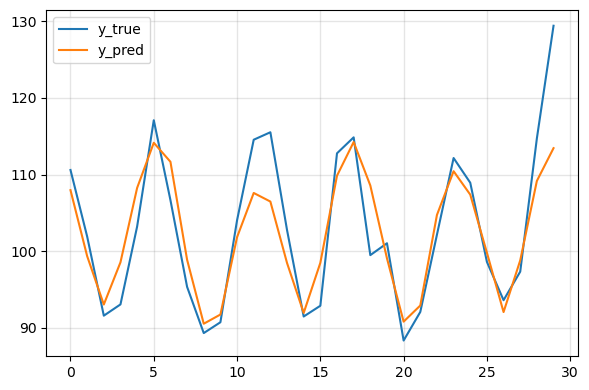

In [12]:
a = plot2d(y_test, y_pred_mof, labels=['y_true', 'y_pred'], figsize=(6, 4), eval_slices='[-1]')

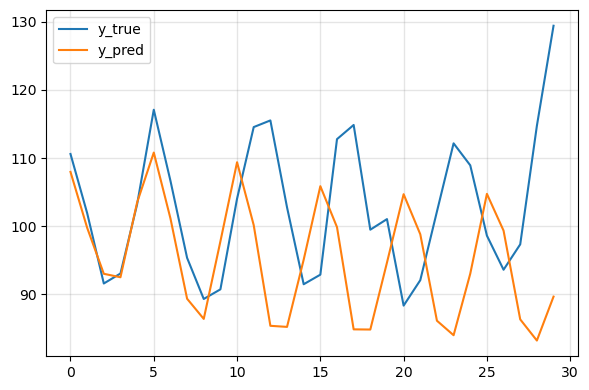

In [13]:
a = plot2d(y_test, y_pred_msf, labels=['y_true', 'y_pred'], figsize=(6, 4), eval_slices='[-1]')

# Pipeline

In [8]:
from spinesTS.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [9]:
multi_reg = Pipeline([
    ('sc', StandardScaler()),
    ('multi_reg', MultiOutputRegressor(LGBMRegressor()))
])

In [10]:
multi_reg.fit(x_train, y_train, eval_set=[(x_test, y_test)], early_stopping_rounds=100, verbose=0)

In [11]:
y_pred = multi_reg.predict(x_test)

In [12]:
r2_score(y_test.T, y_pred.T)

0.8068726243223835

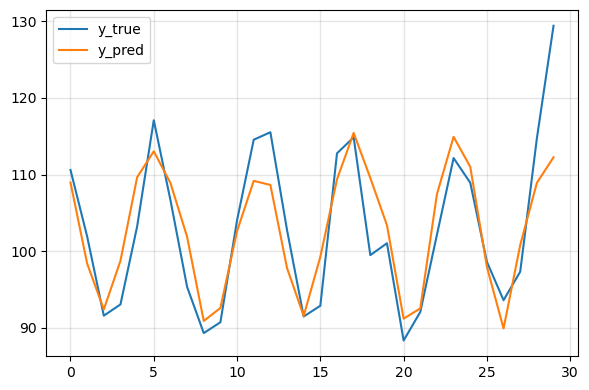

In [13]:
a = plot2d(y_test, y_pred, labels=['y_true', 'y_pred'], figsize=(6, 4), eval_slices='[-1]')

## other algorithm pipeline

In [14]:
from spinesTS.metrics import mean_absolute_error
from spinesTS.metrics import mean_absolute_percentage_error
from lightgbm import LGBMRegressor

In [15]:
multi_reg = Pipeline([
    ('sc', StandardScaler()),
    ('multi_reg', MultiOutputRegressor(LGBMRegressor()))
])
multi_reg.fit(x_train, y_train, eval_set=(x_test, y_test), verbose=0)
y_pred = multi_reg.predict(x_test)
print(f"r2: {r2_score(y_test.T, y_pred.T)}")
print(f"mae: {mean_absolute_error(y_test, y_pred)}")
print(f"mape: {mean_absolute_percentage_error(y_test, y_pred)}")

r2: 0.8055589089422277
mae: 3.1094190438053237
mape: 0.029791289699066813


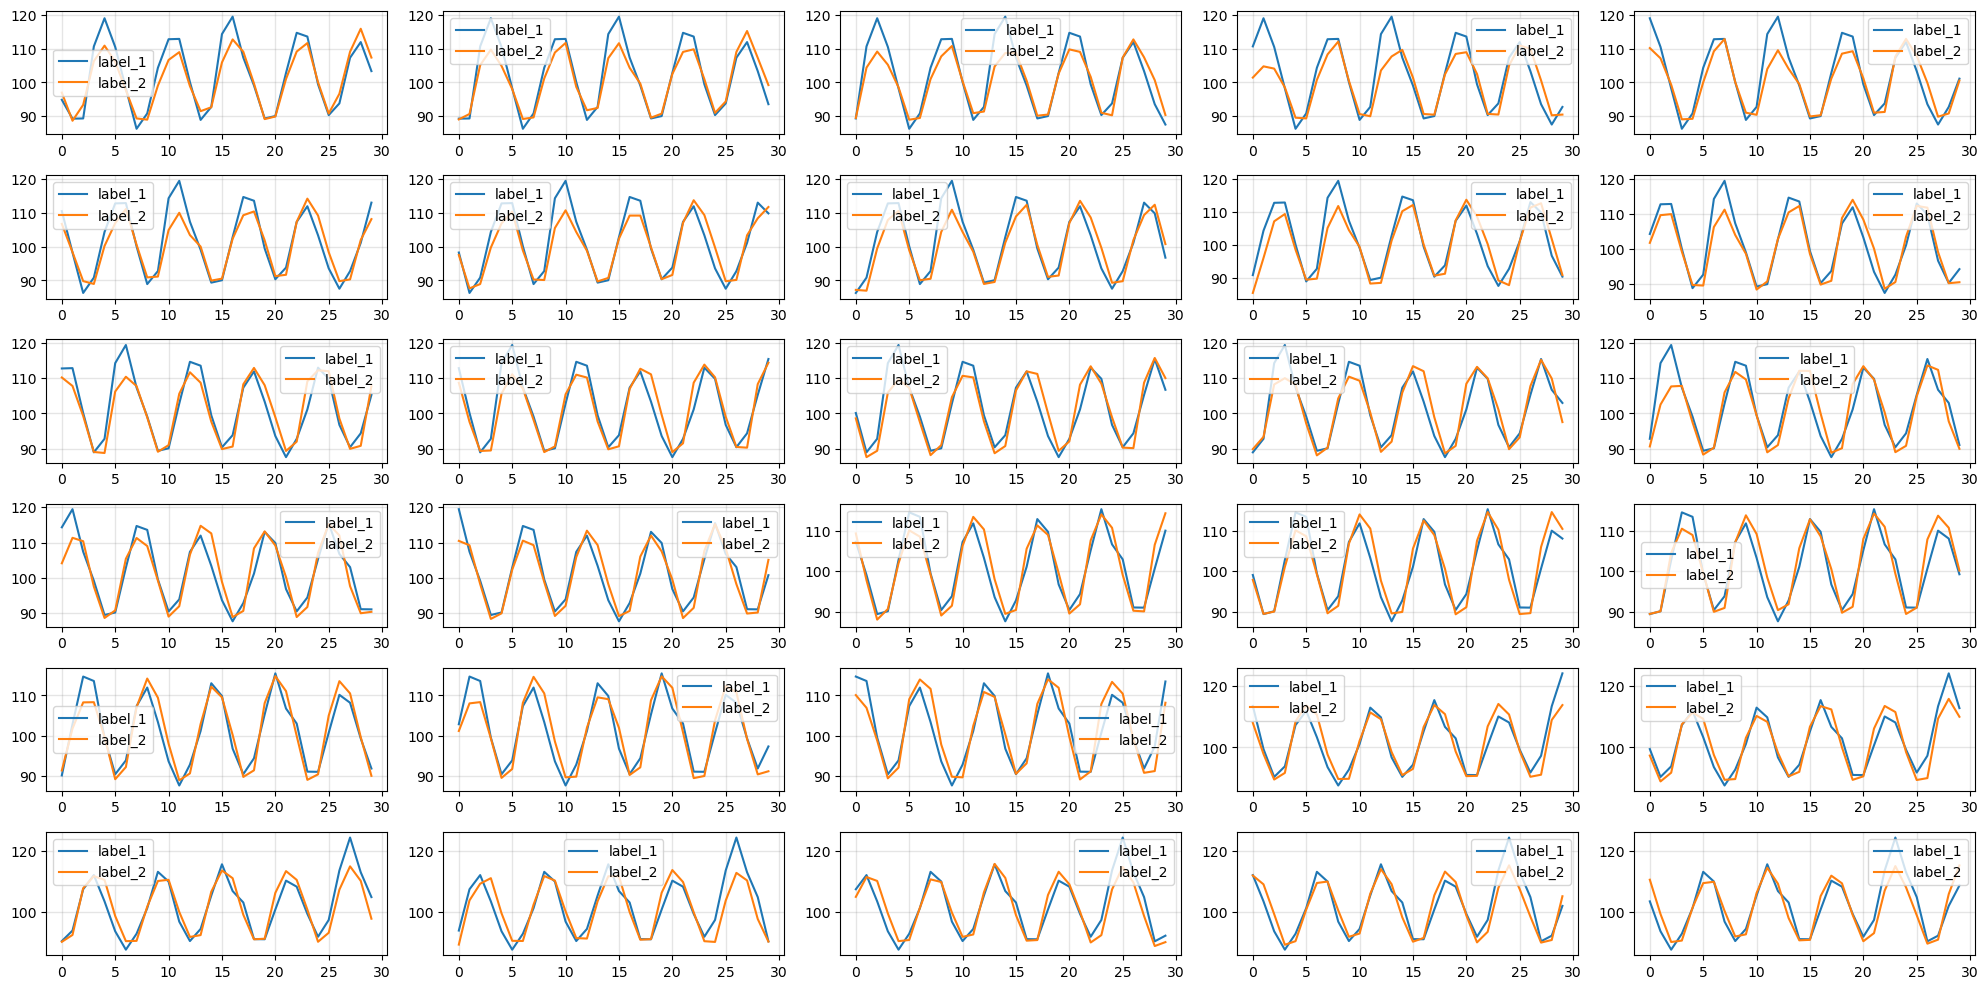

In [16]:
a = plot2d(y_test, y_pred, figsize=(20, 10), eval_slices='[:30]')

## feature generate

r2: 0.7945264955269358
mae: 3.270098108183721
mape: 0.031044316183630176


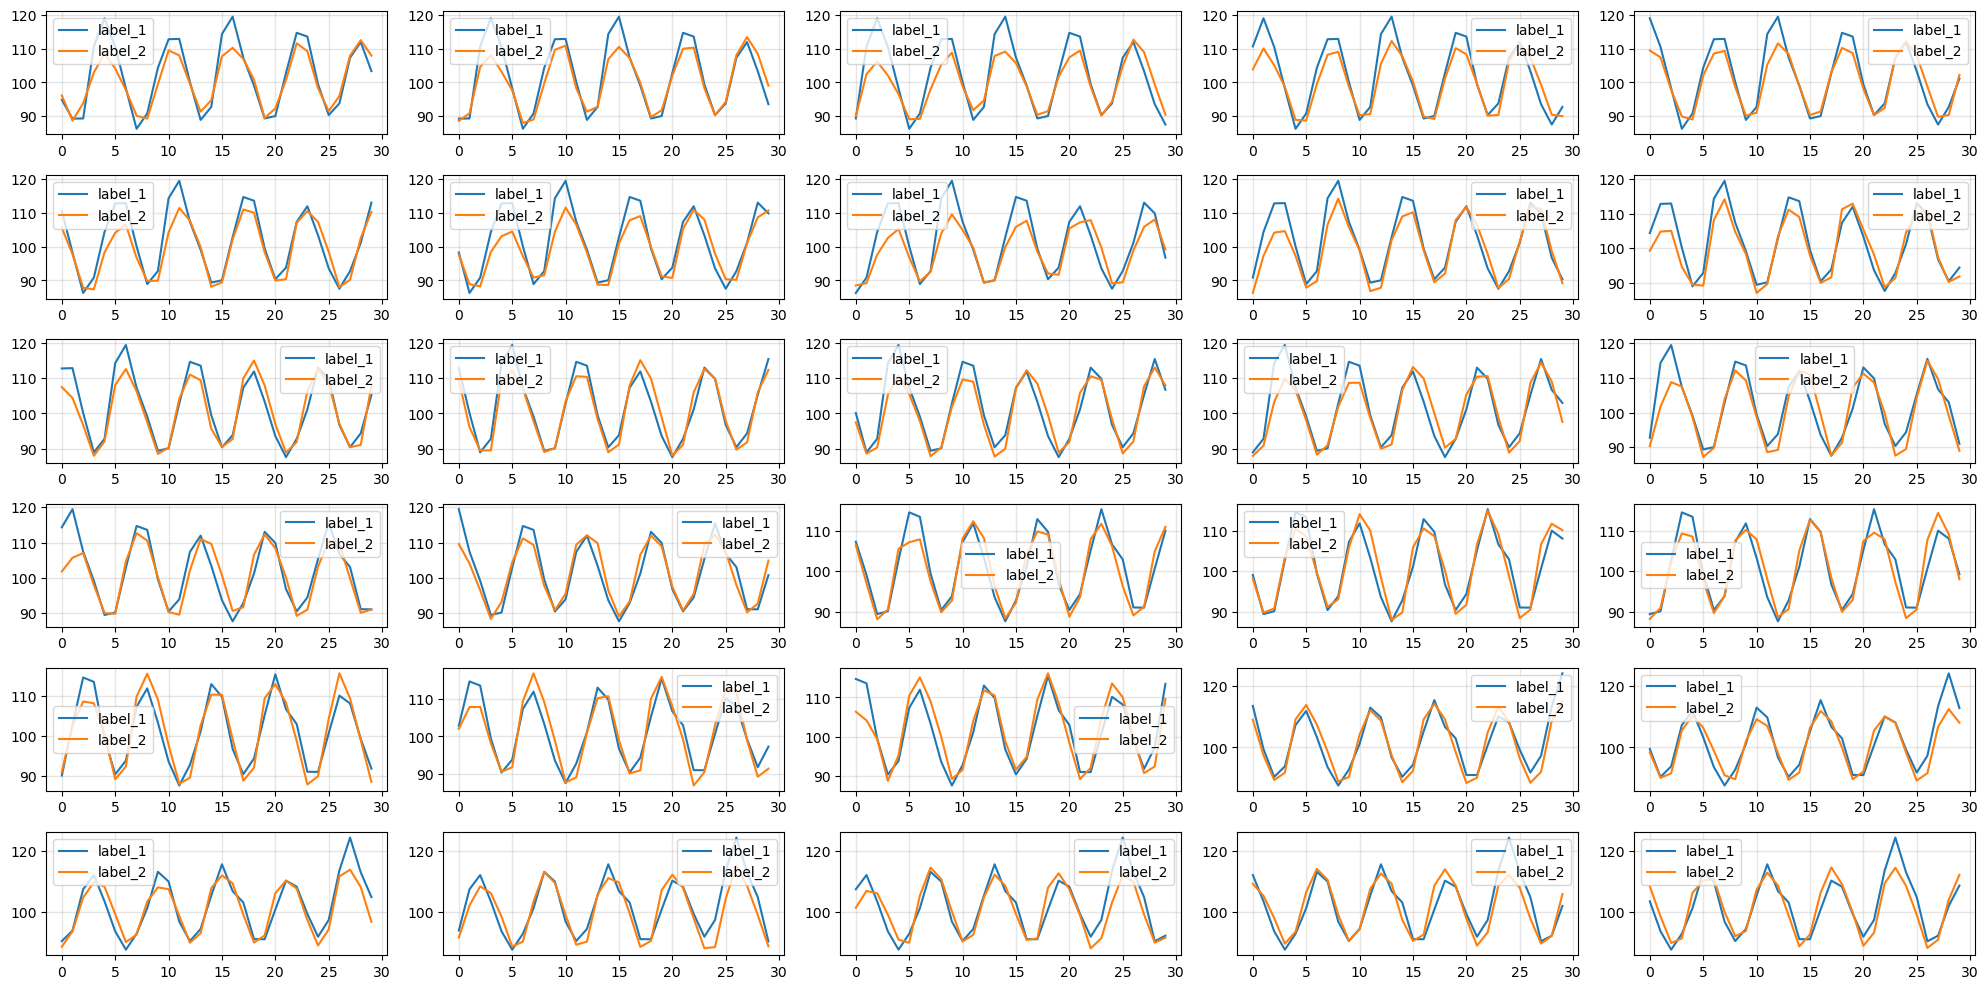

In [17]:
from spinesTS.features_generator import ContinuousFeatureGenerator
from catboost import CatBoostRegressor
multi_reg = Pipeline([
    ('fe', ContinuousFeatureGenerator()),
    ('sc', StandardScaler()),
    ('multi_reg', MultiOutputRegressor(CatBoostRegressor(use_best_model=True)))
])
multi_reg.fit(x_train, y_train, eval_set=([x_test, y_test]), use_best_model=True, verbose=0)
y_pred = multi_reg.predict(x_test)
print(f"r2: {r2_score(y_test.T, y_pred.T)}")
print(f"mae: {mean_absolute_error(y_test, y_pred)}")
print(f"mape: {mean_absolute_percentage_error(y_test, y_pred)}")
a = plot2d(y_test, y_pred, figsize=(20, 10), eval_slices='[:30]')

r2: 0.8280180006456318
mae: 3.005483508137291
mape: 0.028610359084774675


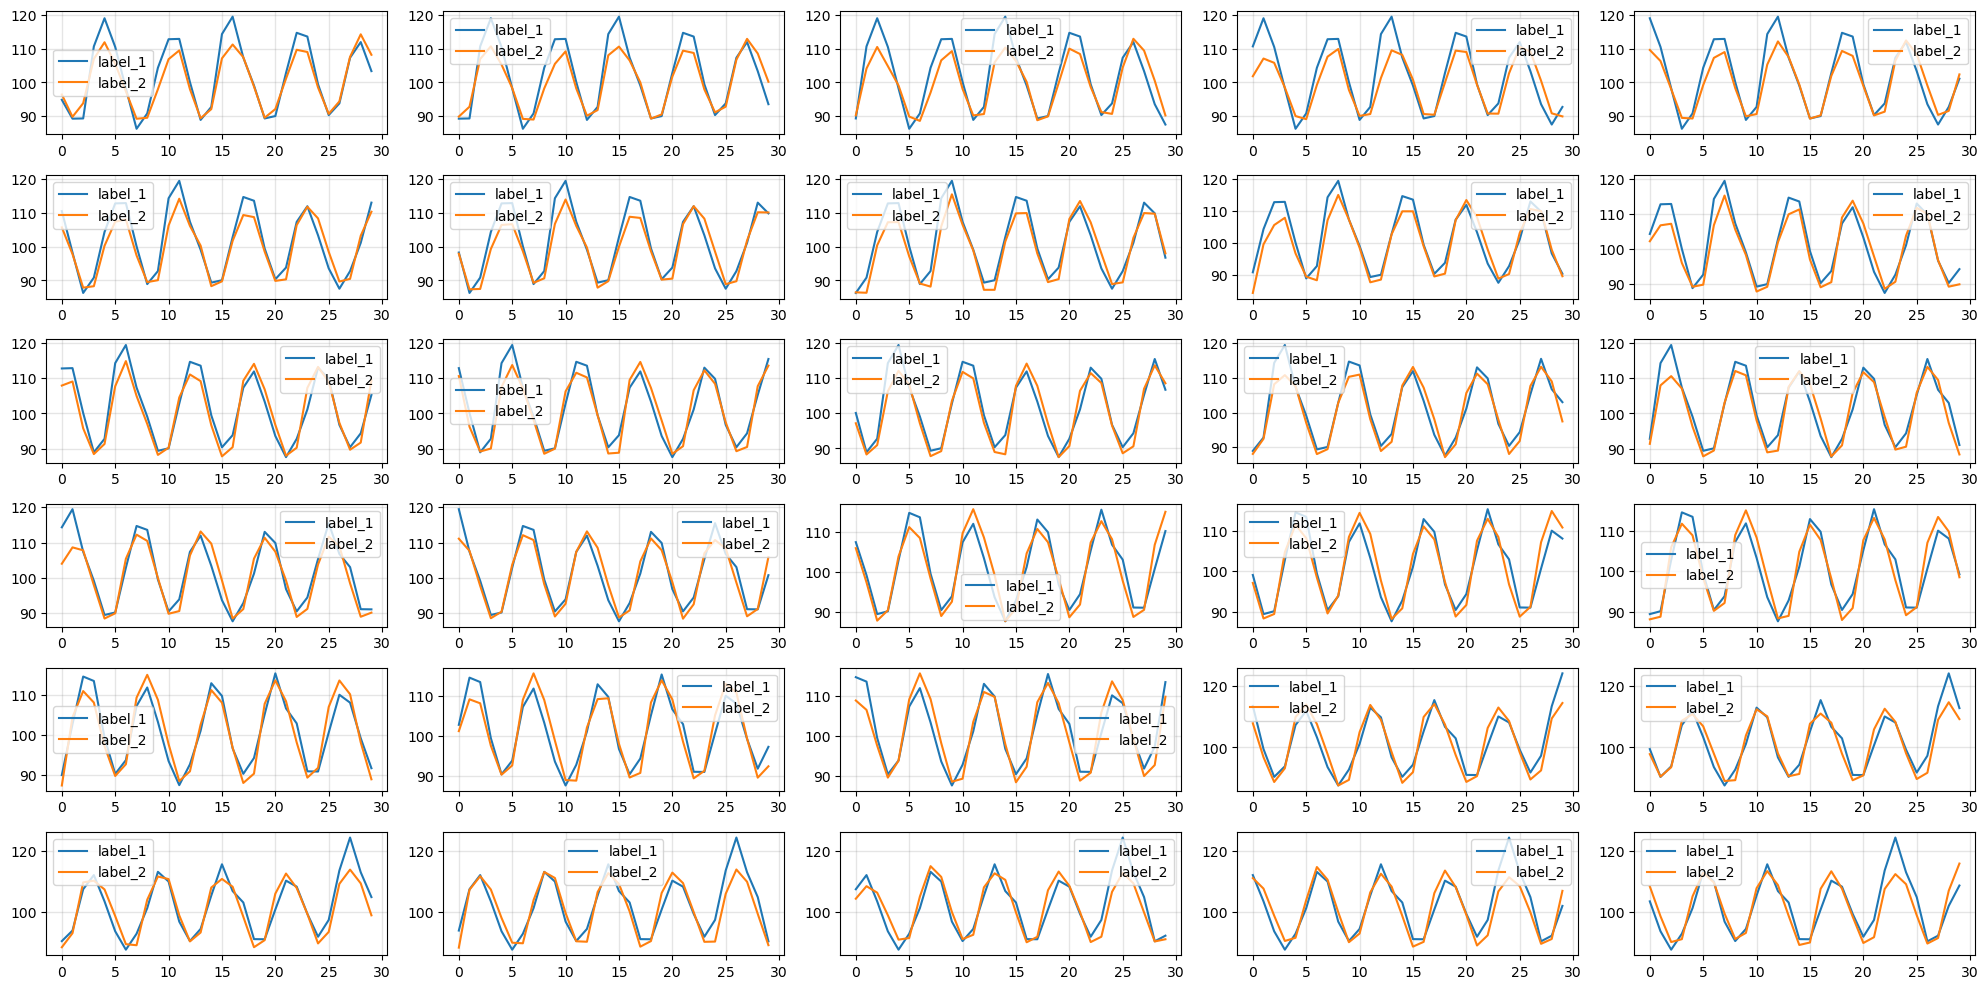

In [18]:
from spinesTS.metrics import *
from catboost import CatBoostRegressor
multi_reg = Pipeline([
    ('multi_reg', MultiOutputRegressor(CatBoostRegressor(use_best_model=True)))
])
multi_reg.fit(x_train, y_train, eval_set=([x_test, y_test]), use_best_model=True, verbose=0)
y_pred = multi_reg.predict(x_test)
print(f"r2: {r2_score(y_test.T, y_pred.T)}")
print(f"mae: {mean_absolute_error(y_test, y_pred)}")
print(f"mape: {mean_absolute_percentage_error(y_test, y_pred)}")
a = plot2d(y_test, y_pred, figsize=(20, 10), eval_slices='[:30]')

r2: 0.7953262093137735
mae: 3.2505164525113104
mape: 0.030827401280239544


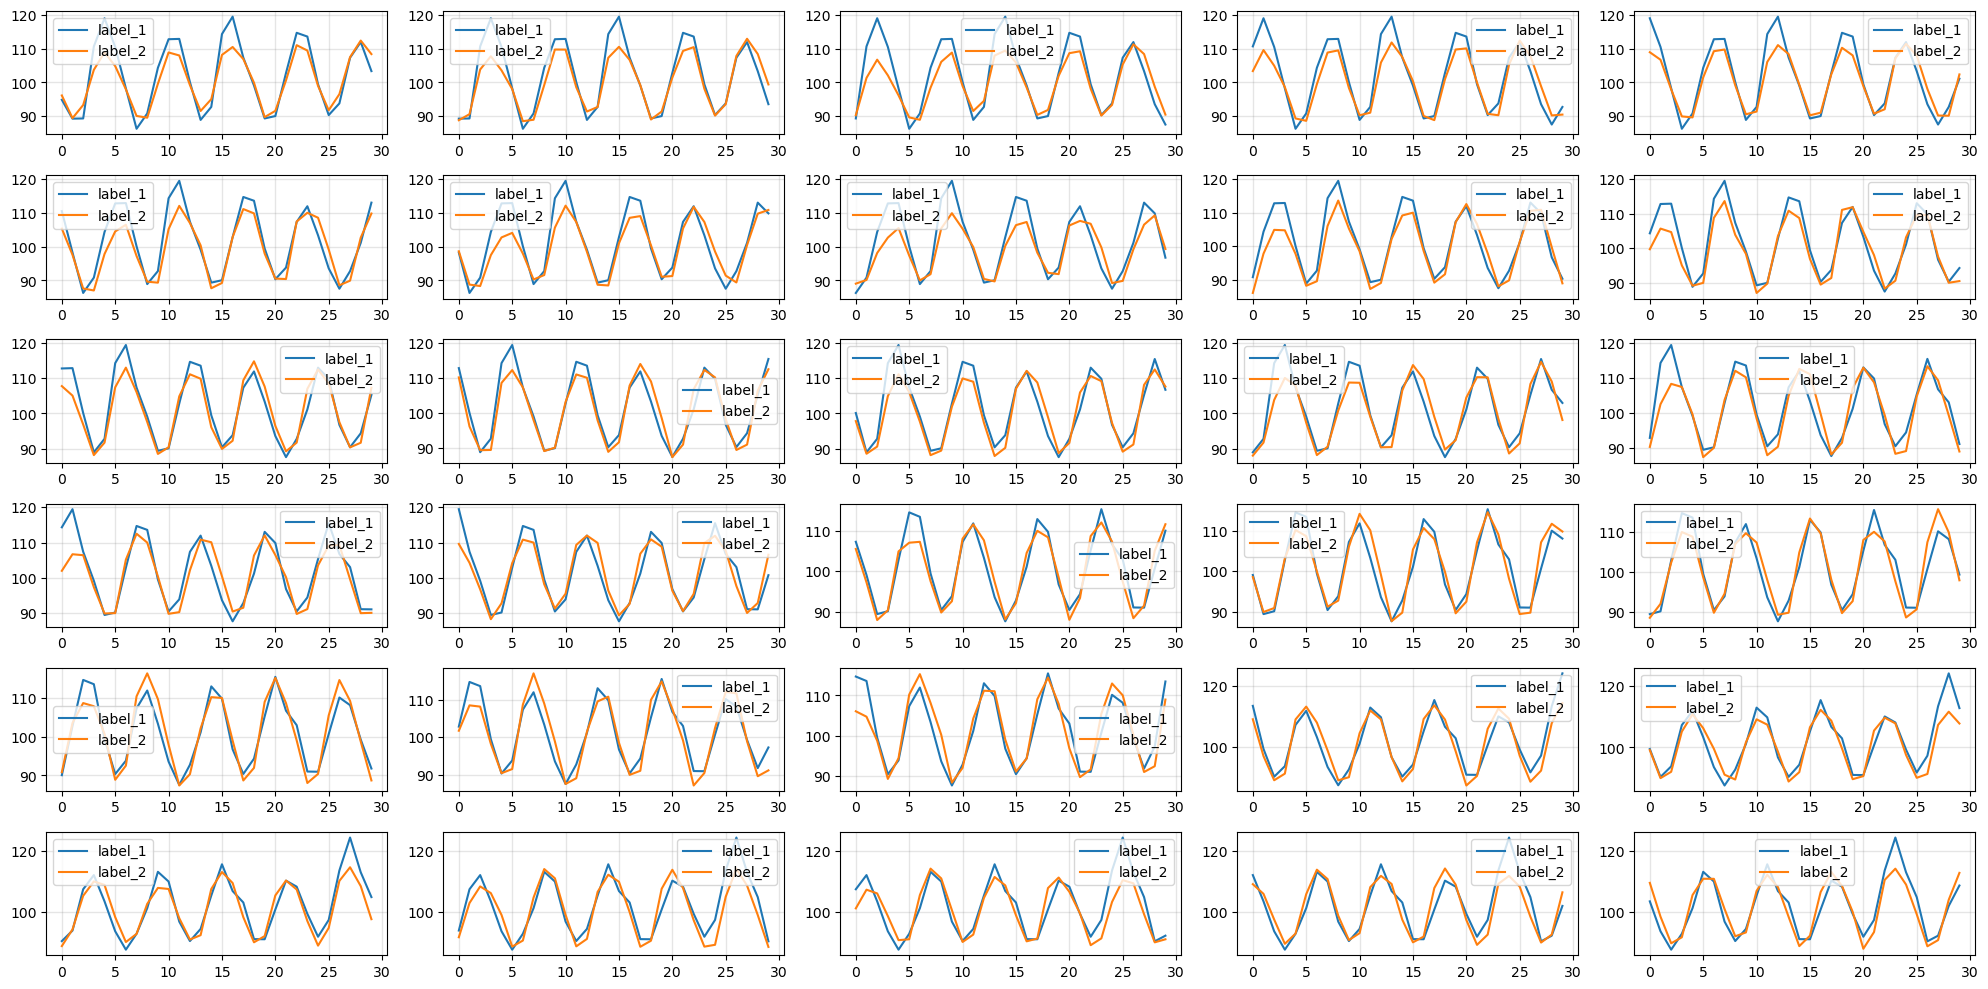

In [19]:
from spinesTS.metrics import *
from spinesTS.features_generator import ContinuousFeatureGenerator
from catboost import CatBoostRegressor
multi_reg = Pipeline([
    ('fe', ContinuousFeatureGenerator()),
    ('multi_reg', MultiOutputRegressor(CatBoostRegressor(use_best_model=True)))
])
multi_reg.fit(x_train, y_train, eval_set=([x_test, y_test]), use_best_model=True, verbose=0)
y_pred = multi_reg.predict(x_test)
print(f"r2: {r2_score(y_test.T, y_pred.T)}")
print(f"mae: {mean_absolute_error(y_test, y_pred)}")
print(f"mape: {mean_absolute_percentage_error(y_test, y_pred)}")
a = plot2d(y_test, y_pred, figsize=(20, 10), eval_slices='[:30]')

# WideGBRT

In [20]:
from spinesTS.ml_model import GBRTPreprocessing, WideGBRT

In [23]:
data = LoadElectricDataSets()
y_name = 'value'
data

date     value
0    01-01-1985   72.5052
1    02-01-1985   70.6720
2    03-01-1985   62.4502
3    04-01-1985   57.4714
4    05-01-1985   55.3151
..          ...       ...
392  09-01-2017   98.6154
393  10-01-2017   93.6137
394  11-01-2017   97.3359
395  12-01-2017  114.7212
396  01-01-2018  129.4048

[397 rows x 2 columns]

r2: 0.8348436261752354
mae: 2.8069209325309585
mape: 0.026574816380184232


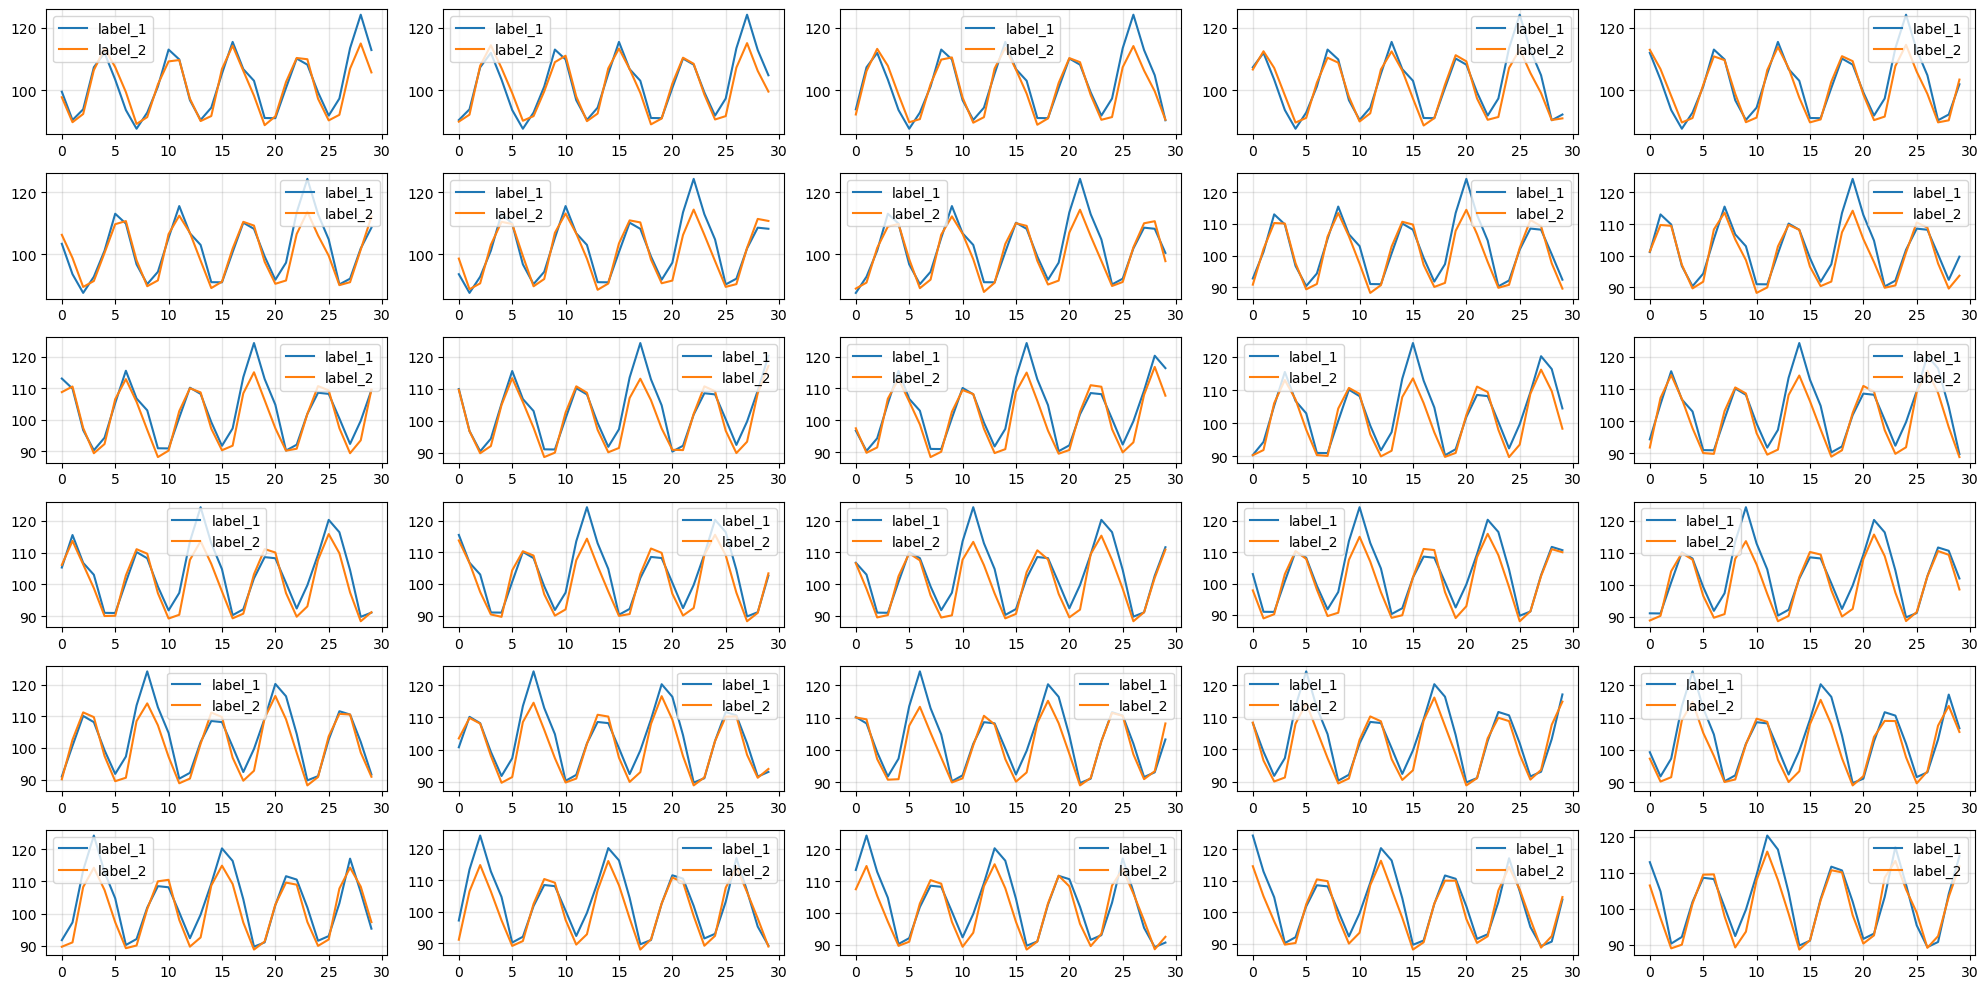

In [24]:
gbrt_processor = GBRTPreprocessing(128, 30, y_name, date_col='date')
gbrt_processor.fit(data)

x_train, x_test, y_train, y_test = gbrt_processor.transform(data)

from spinesTS.metrics import *
from catboost import CatBoostRegressor
wide_gbrt = WideGBRT(model=CatBoostRegressor(use_best_model=True))
wide_gbrt.fit(x_train, y_train, eval_set=([x_test, y_test]), use_best_model=True, verbose=0)
y_pred = wide_gbrt.predict(x_test)
print(f"r2: {r2_score(y_test.T, y_pred.T)}")
print(f"mae: {mean_absolute_error(y_test, y_pred)}")
print(f"mape: {mean_absolute_percentage_error(y_test, y_pred)}")
a = plot2d(y_test, y_pred, figsize=(20, 10), eval_slices='[:30]')

r2: 0.8418452126268949
mae: 2.8171850014054076
mape: 0.0264894307043648


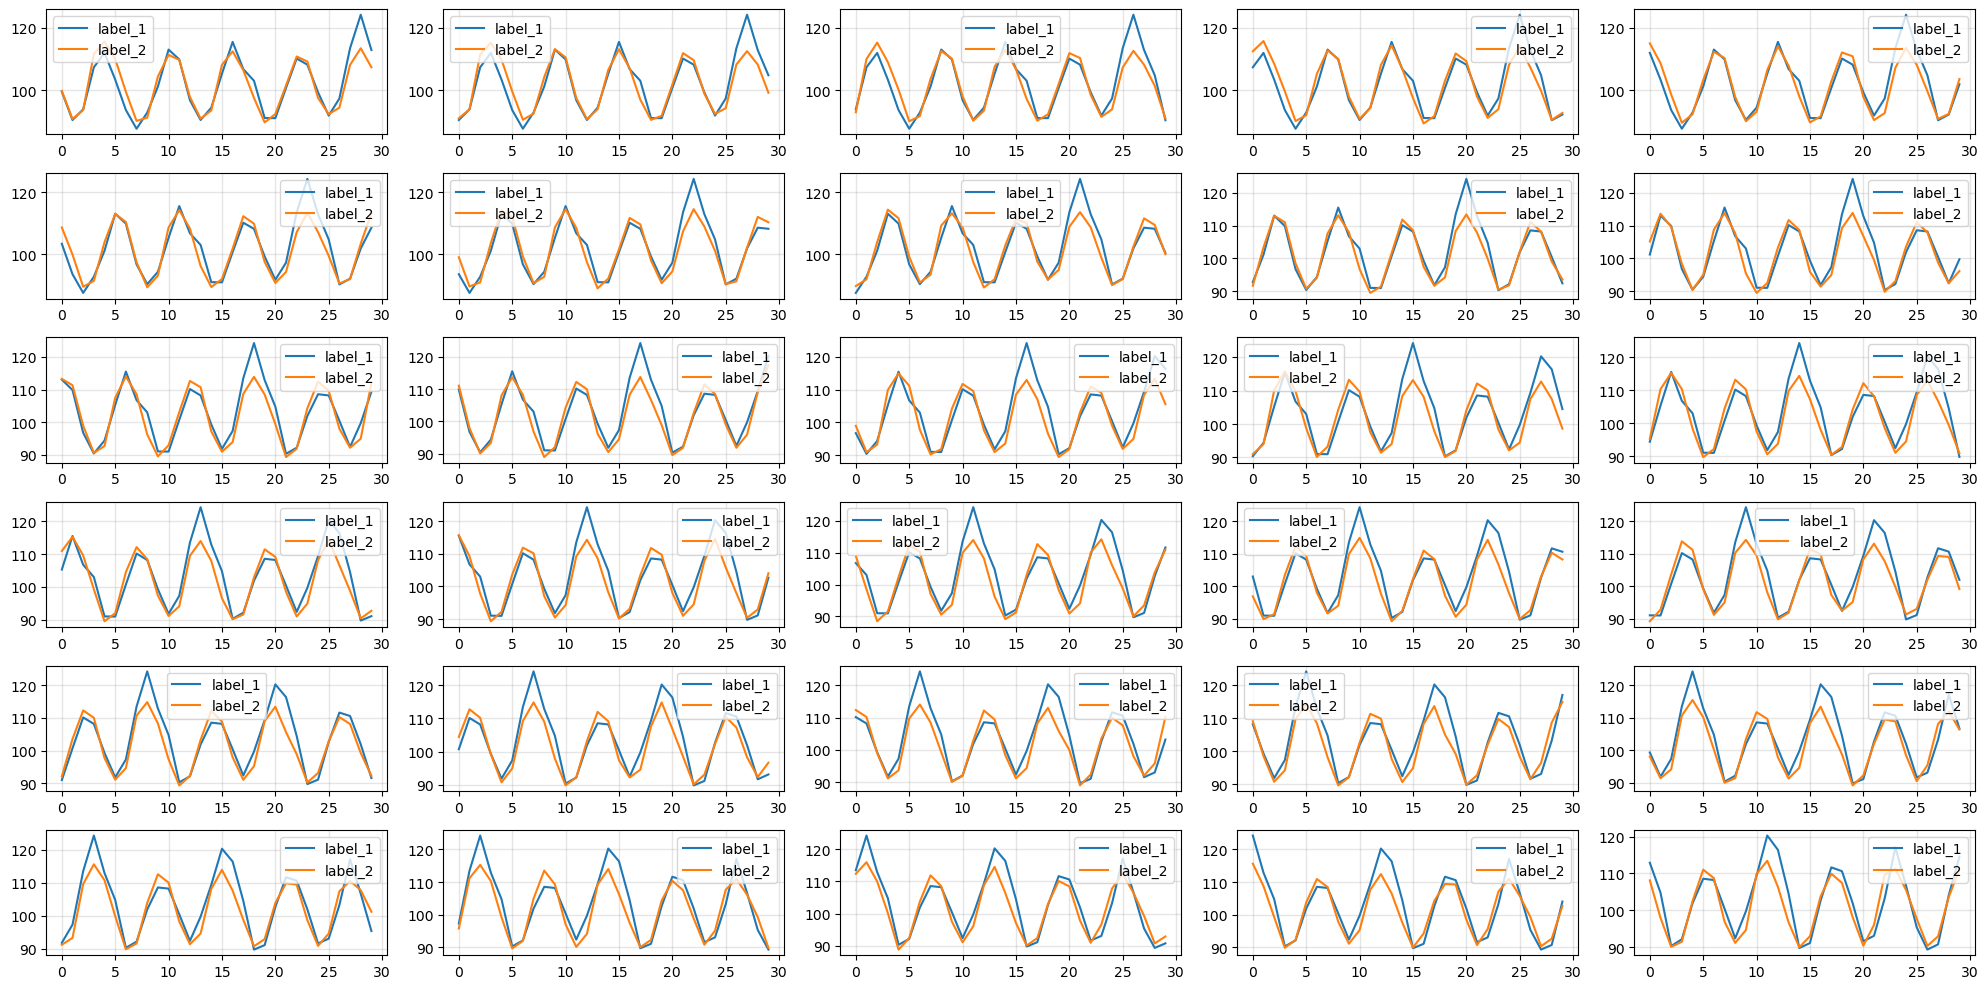

In [25]:
gbrt_processor = GBRTPreprocessing(128, 30, y_name, date_col='date', differential_n=0)
gbrt_processor.fit(electric)
x_train, x_test, y_train, y_test = gbrt_processor.transform(data)
from spinesTS.metrics import *
from catboost import CatBoostRegressor
wide_gbrt = WideGBRT(model=CatBoostRegressor(use_best_model=True))
wide_gbrt.fit(x_train, y_train, eval_set=([x_test, y_test]), use_best_model=True, verbose=0)
y_pred = wide_gbrt.predict(x_test)
print(f"r2: {r2_score(y_test.T, y_pred.T)}")
print(f"mae: {mean_absolute_error(y_test, y_pred)}")
print(f"mape: {mean_absolute_percentage_error(y_test, y_pred)}")
a = plot2d(y_test, y_pred, figsize=(20, 10), eval_slices='[:30]')

x_train shape is (270, 30), x_test shape is (68, 30),y_train shape is (270, 30),y_test shape is (68, 30)
Model successfully initialization...
r2_score is 0.8043121220762401


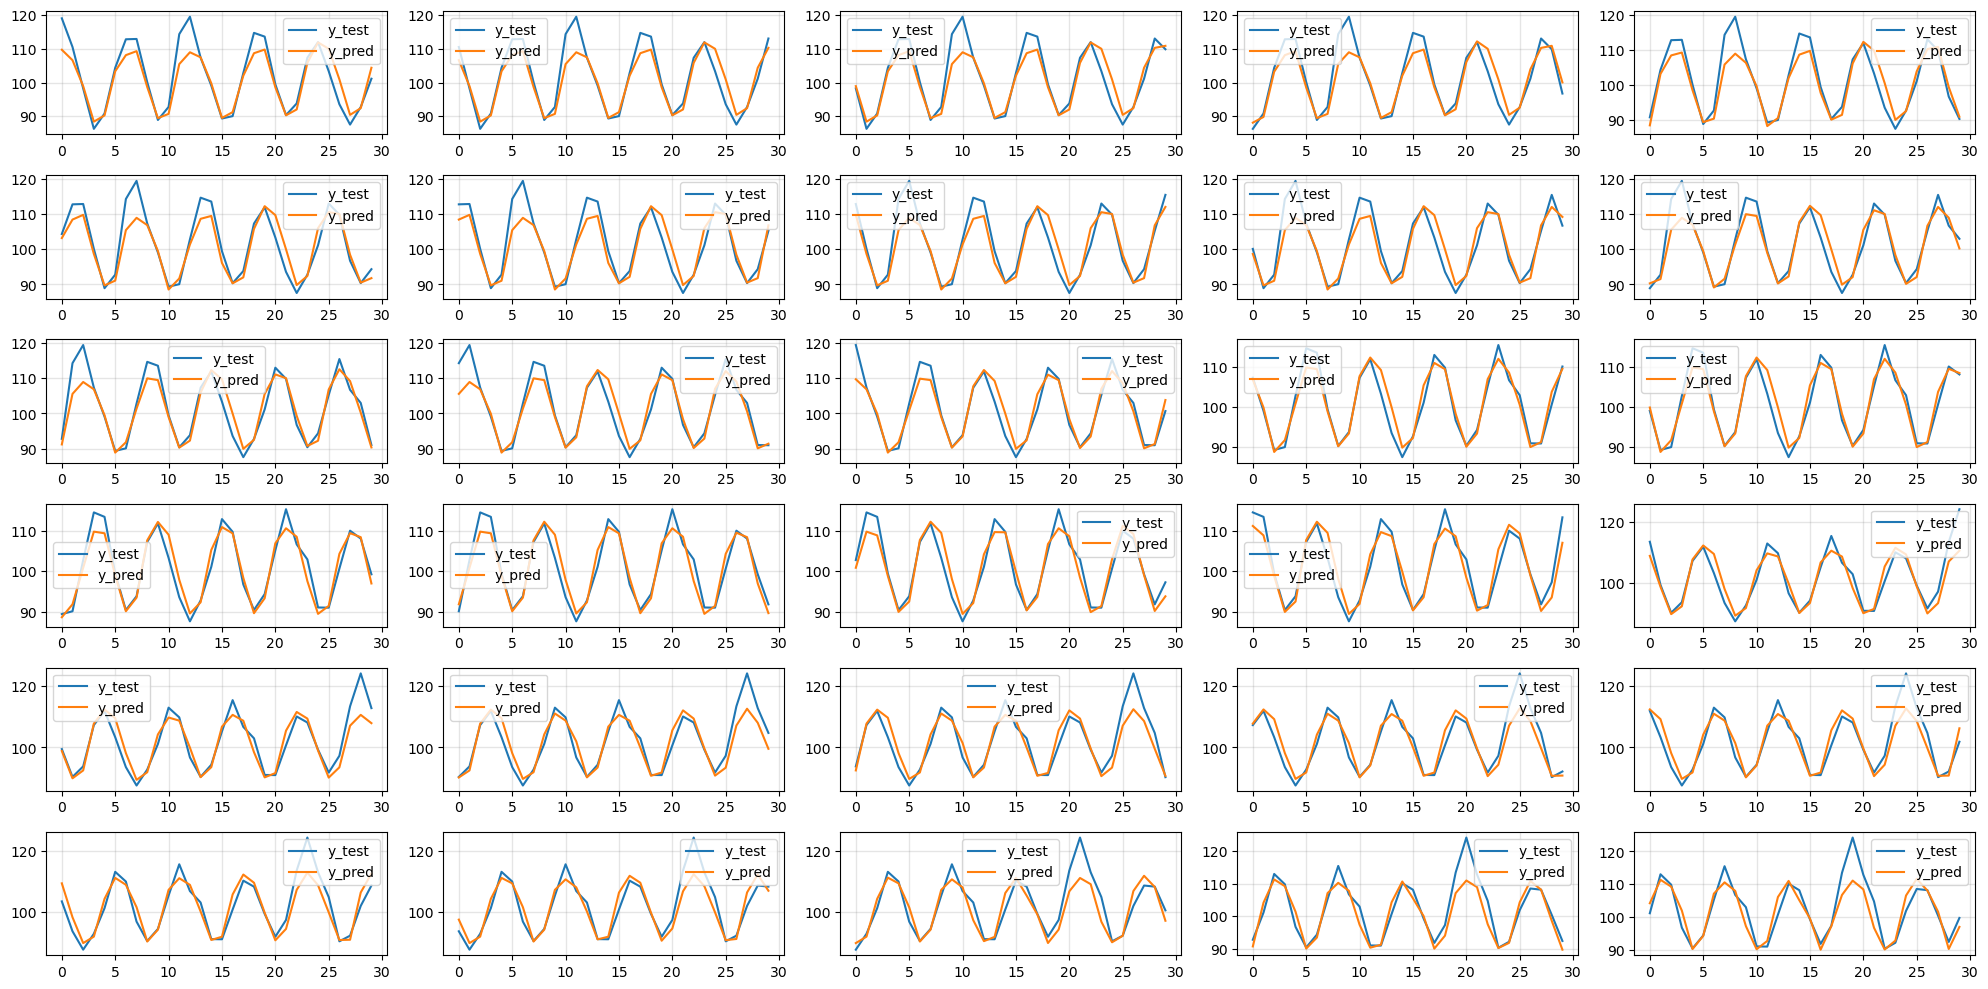

In [34]:
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt

from spinesTS.pipeline import Pipeline
from spinesTS.data import LoadElectricDataSets
from spinesTS.ml_model import MultiStepRegressor
from spinesTS.preprocessing import split_series
from spinesTS.plotting import plot2d


# load data
df = LoadElectricDataSets()

# split data
x_train, x_test, y_train, y_test = split_series(
    df['value'], 
    df['value'],
    # sliding window size, every 30 before days to predict after days
    window_size=30, 
    # predict after 30 days goods incoming
    pred_steps=30, 
    train_size=0.8
)

print(f"x_train shape is {x_train.shape}, "
      f"x_test shape is {x_test.shape}," 
      f"y_train shape is {y_train.shape},"
      f"y_test shape is {y_test.shape}")

# Assemble the model using Pipeline class
model = MultiStepRegressor(LGBMRegressor(random_state=2022))
print("Model successfully initialization...")

# fitting model
model.fit(x_train, y_train, eval_set=(x_test, y_test), verbose=0)
print(f"r2_score is {model.score(x_test, y_test)}")

# plot the predicted results
fig = plot2d(y_test, model.predict(x_test), figsize=(20, 10), 
       eval_slices='[:30]', labels=['y_test', 'y_pred'])
plt.show()

x_train shape is (270, 30), x_test shape is (68, 30),y_train shape is (270, 30),y_test shape is (68, 30)
Model successfully initialization...
r2_score is 0.8200335958448903


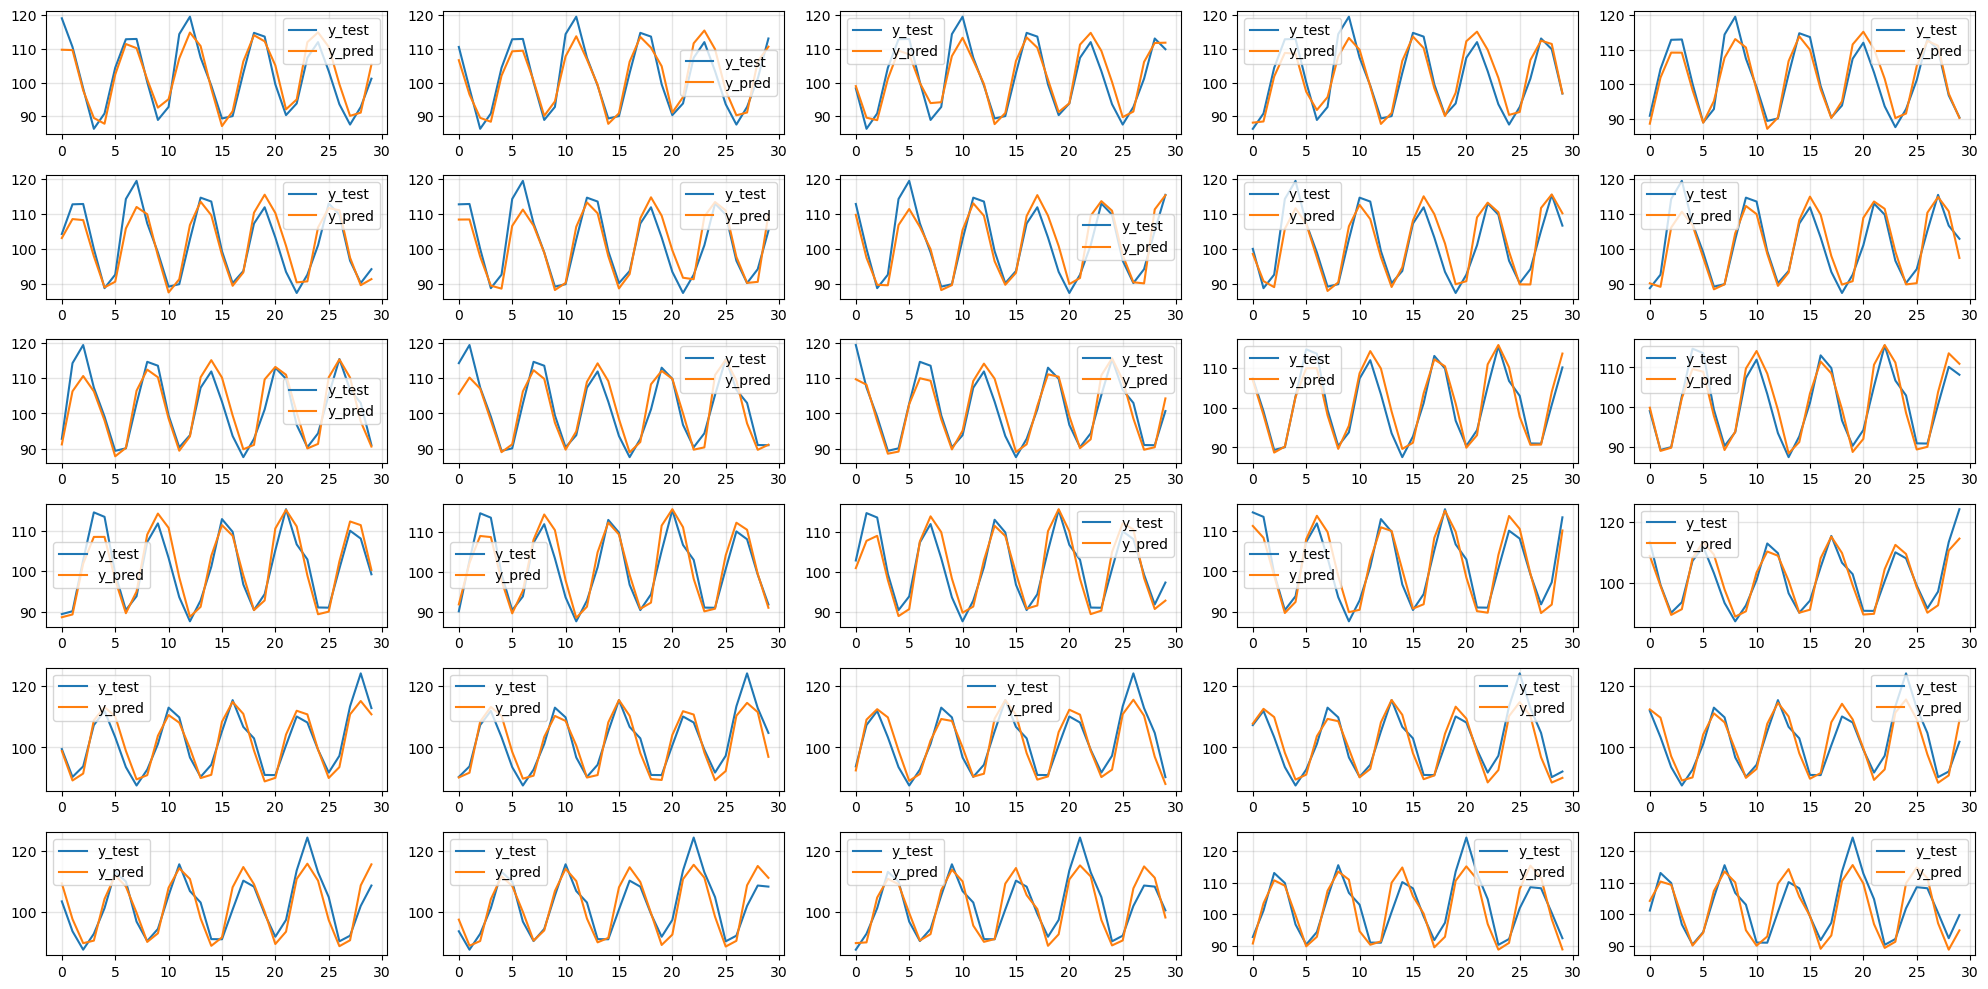

In [35]:
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt

from spinesTS.data import LoadElectricDataSets
from spinesTS.ml_model import MultiOutputRegressor
from spinesTS.preprocessing import split_series
from spinesTS.plotting import plot2d


# load data
df = LoadElectricDataSets()

# split data
x_train, x_test, y_train, y_test = split_series(
    df['value'], 
    df['value'],
    # sliding window size, every 30 before days to predict after days
    window_size=30, 
    # predict after 30 days goods incoming
    pred_steps=30, 
    train_size=0.8
)

print(f"x_train shape is {x_train.shape}, "
      f"x_test shape is {x_test.shape}," 
      f"y_train shape is {y_train.shape},"
      f"y_test shape is {y_test.shape}")

# Assemble the model using Pipeline class
model = MultiOutputRegressor(LGBMRegressor(random_state=2022))
print("Model successfully initialization...")

# fitting model
model.fit(x_train, y_train, eval_set=(x_test, y_test), verbose=0)
print(f"r2_score is {model.score(x_test, y_test)}")

# plot the predicted results
fig = plot2d(y_test, model.predict(x_test), figsize=(20, 10), 
       eval_slices='[:30]', labels=['y_test', 'y_pred'])
plt.show()

x_train shape is (192, 150), x_test shape is (48, 150),y_train shape is (192, 30),y_test shape is (48, 30)
Model successfully initialization...
r2_score is 0.835119993928231


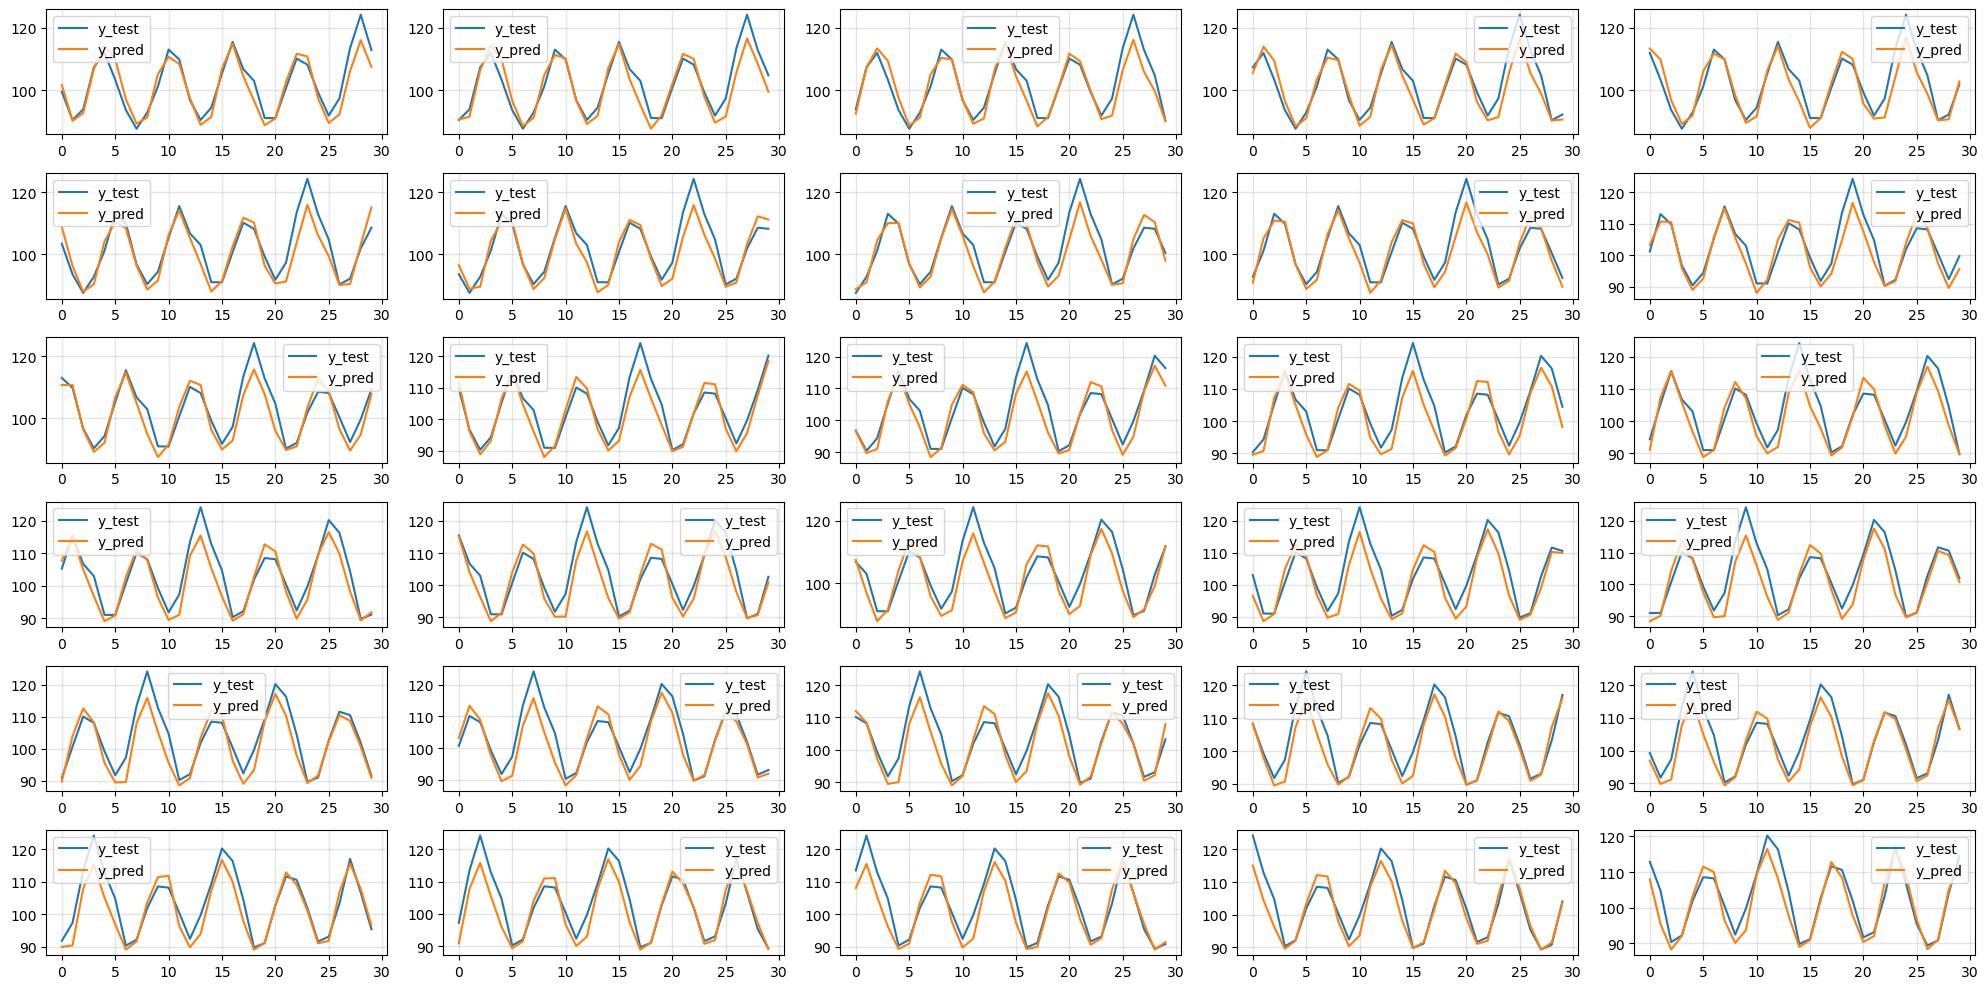

In [2]:
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt

from spinesTS.data import LoadElectricDataSets
from spinesTS.ml_model import GBRTPreprocessing, WideGBRT
from spinesTS.preprocessing import split_series
from spinesTS.plotting import plot2d


# load data
df = LoadElectricDataSets()

# split data and generate new features
gbrt_processor = GBRTPreprocessing(in_features=128, out_features=30, 
                                   target_col='value', train_size=0.8, date_col='date',
                                   differential_n=1  # The order of data differentiation.
                                   )
gbrt_processor.fit(df)

x_train, x_test, y_train, y_test = gbrt_processor.transform(df)

print(f"x_train shape is {x_train.shape}, "
      f"x_test shape is {x_test.shape}," 
      f"y_train shape is {y_train.shape},"
      f"y_test shape is {y_test.shape}")

# Assemble the model using Pipeline class
model = WideGBRT(model=LGBMRegressor(random_state=2022))
print("Model successfully initialization...")

# fitting model
model.fit(x_train, y_train, eval_set=(x_test, y_test), verbose=0)
print(f"r2_score is {model.score(x_test, y_test)}")

# plot the predicted results
fig = plot2d(y_test, model.predict(x_test), figsize=(20, 10), 
       eval_slices='[:30]', labels=['y_test', 'y_pred'])
plt.show()